# Neighbour2Neighbor Experiment

[CVPR 2021: Neighbor2Neighbor: Self-Supervised Denoising from Single Noisy Images](https://openaccess.thecvf.com/content/CVPR2021/papers/Huang_Neighbor2Neighbor_Self-Supervised_Denoising_From_Single_Noisy_Images_CVPR_2021_paper.pdf)

Key idea: 
- By utilizing a random neighbor subsampler on a single noisy image, we can generate two pairs of noisy images that share a similar clean reference, addressing certain limitations of the noise2noise approach.
- To compensate for discrepancies between the true pixel values of the subsampled noisy images, an extra regularization term is incorporated into the loss function.

limitation:
- The intrinsic similarity among neighboring pixels might not be robust enough to ensure effective denoising, particularly when considering spatial correlations. This could potentially diminish the performance of the Nb2Nb (Neighbor to Neighbor) approach.

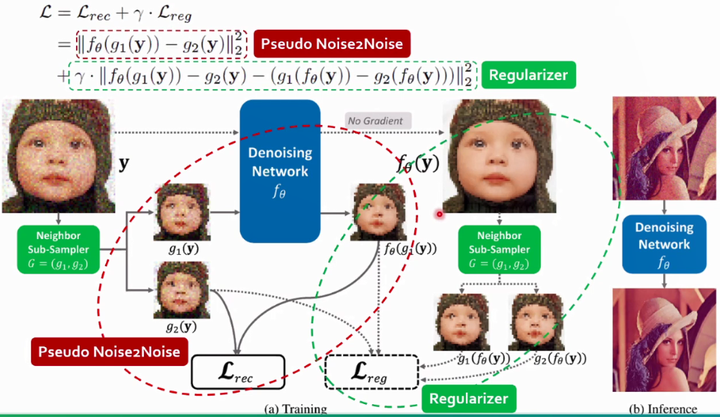

In [1]:
import os
import copy
import json
import time

import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image, timer_decorator
from module.datasets import load_4d_dicom, save_4d_dicom, restore_data, split_data

from module.models import UNet2D
from module.datasets import Nb2Nb2D_Dataset
from module.loss import SSIMLoss, SSIM_MAELoss, SSIM_MSELoss



import h5py
from tqdm.notebook import tqdm


import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


# 0. Load preprocessed data

Noisy data...float32 (shape:(11, 24, 71, 192, 192); range:[0.0,1.0]; mean:0.4927044212818146); std:0.022372599691152573
{'original_min': -32768.0, 'original_max': 32767.0, 'z_score_mean': 201.4710693359375, 'z_score_std_dev': 1407.2664794921875, 'noise_min': -24.626427916933984, 'noise_max': 25.3497884510521}


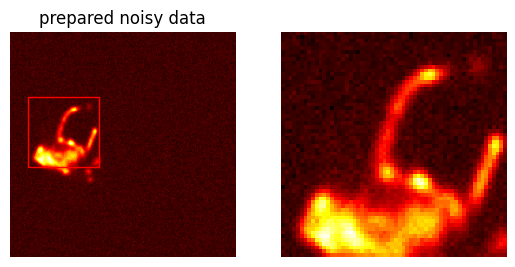

In [2]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_gaussian_0.50_batch.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = json.loads(f['restore_info'][()])
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)

display_image_in_detail(noisy_data[0, 11, 38], title="prepared noisy data")

# 1. Create Nb2NbDataset with random neighbor subsampler

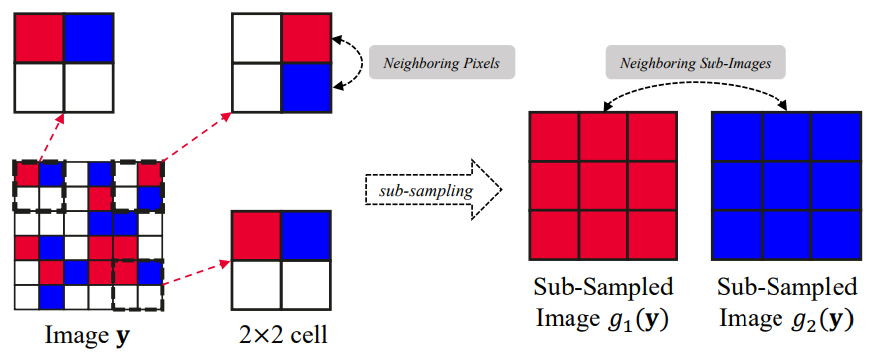

In [3]:
## split ndarray data
train_data, val_data, test_data = split_data(noisy_data)

## add channel dim
train_tensor = torch.tensor(train_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
val_tensor = torch.tensor(val_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
test_tensor = torch.tensor(test_data[..., np.newaxis, :, :, :], dtype=torch.float32) 

print(f"train_tensor:\n {train_tensor.dtype}; shape:{train_tensor.shape}; range:({torch.min(train_tensor)},{torch.max(train_tensor)}); mean:{torch.mean(train_tensor)}; std:{torch.std(train_tensor)}")
print(f"val_tensor:\n {val_tensor.dtype}; shape:{val_tensor.shape}; range:({torch.min(val_tensor)},{torch.max(val_tensor)}); mean:{torch.mean(val_tensor)}; std:{torch.std(val_tensor)}")
print(f"test_tensor:\n {test_tensor.dtype}; shape:{test_tensor.shape}; range:({torch.min(test_tensor)},{torch.max(test_tensor)}); mean:{torch.mean(test_tensor)}; std:{torch.std(test_tensor)}")


# create Nb2Nb dataset 
train_dataset = Nb2Nb2D_Dataset(train_tensor, k=2)
val_dataset = Nb2Nb2D_Dataset(val_tensor, k=2)
test_dataset = Nb2Nb2D_Dataset(test_tensor, k=2)

print(f"train_dataset: {len(train_dataset)}")
print(f"val_dataset: {len(val_dataset)}")
print(f"test_dataset: {len(test_dataset)}")


# create dataloader
batch_size = 16
num_workers = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_tensor:
 torch.float32; shape:torch.Size([8, 24, 1, 71, 192, 192]); range:(0.0,0.9951097369194031); mean:0.49275916814804077; std:0.022343063727021217
val_tensor:
 torch.float32; shape:torch.Size([2, 24, 1, 71, 192, 192]); range:(0.009302973747253418,0.9902557730674744); mean:0.4927810728549957; std:0.022457370534539223
test_tensor:
 torch.float32; shape:torch.Size([1, 24, 1, 71, 192, 192]); range:(0.002076786942780018,1.0); mean:0.4927551746368408; std:0.02243882790207863
train_dataset: 13632
val_dataset: 3408
test_dataset: 1704


Batch 1
slice_2d: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9719680547714233,0.30213743448257446); mean:0.49217525124549866; std:0.02060507796704769
g1: torch.float32 torch.Size([16, 1, 96, 96]) range:(0.9542509317398071,0.3418601453304291); mean:0.49215877056121826; std:0.020619284361600876
g2: torch.float32 torch.Size([16, 1, 96, 96]) range:(0.955330491065979,0.30213743448257446); mean:0.4921642541885376; std:0.020572250708937645


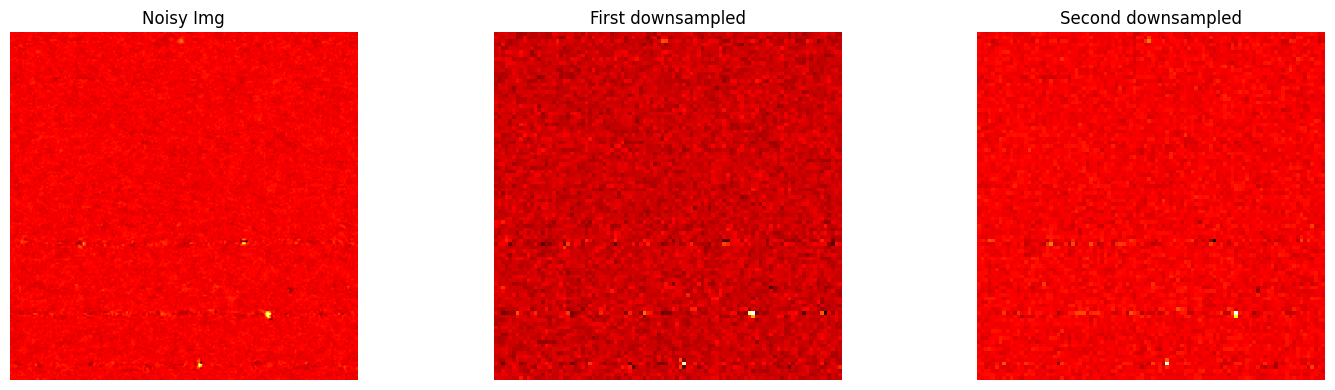

Batch 2
slice_2d: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9707074165344238,0.15019354224205017); mean:0.4943642020225525; std:0.025935787707567215
g1: torch.float32 torch.Size([16, 1, 96, 96]) range:(0.9598786234855652,0.15019354224205017); mean:0.49437448382377625; std:0.025970840826630592
g2: torch.float32 torch.Size([16, 1, 96, 96]) range:(0.9612298011779785,0.1865292489528656); mean:0.49438032507896423; std:0.025930078700184822


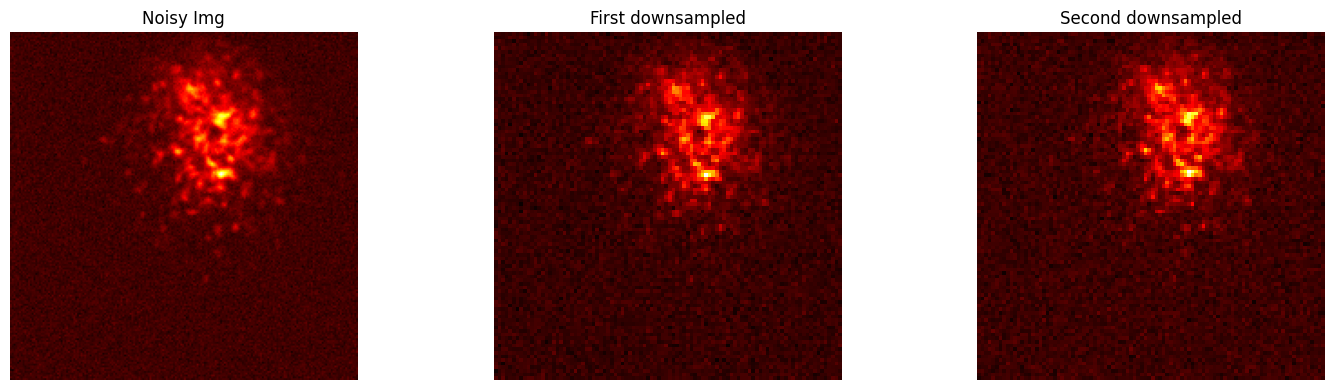

Batch 3
slice_2d: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9721978902816772,0.10880036652088165); mean:0.4935014545917511; std:0.024950554594397545
g1: torch.float32 torch.Size([16, 1, 96, 96]) range:(0.9721978902816772,0.28717291355133057); mean:0.49351343512535095; std:0.024922681972384453
g2: torch.float32 torch.Size([16, 1, 96, 96]) range:(0.9610317945480347,0.2690368592739105); mean:0.4934998154640198; std:0.02493860386312008


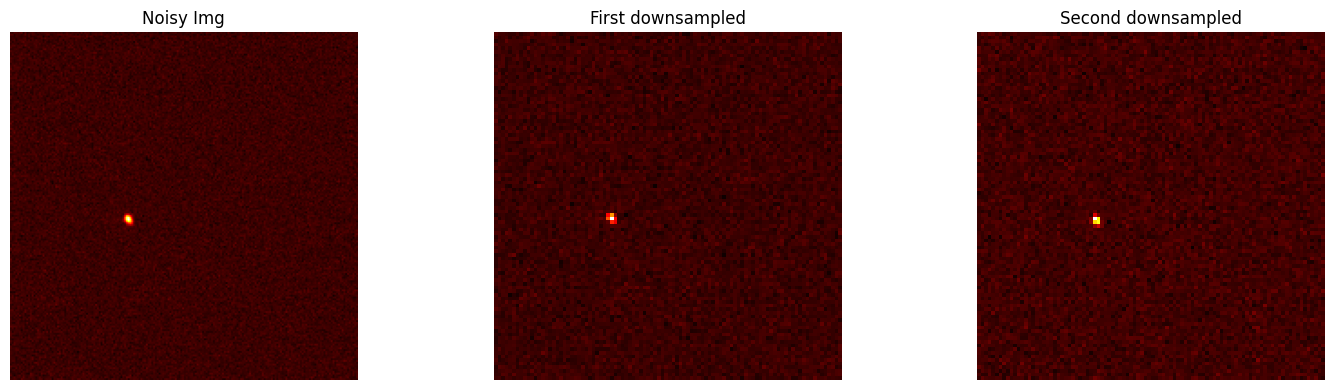

In [4]:
# example batch plot
num_batches_to_display = 3  # for example, show 3 batches

# Iterate through the DataLoader
for batch_idx, (slice_2d, g1, g2) in enumerate(train_loader):
    
    # Print data details
    print(f"Batch {batch_idx + 1}")
    print(f"slice_2d: {slice_2d.dtype} {slice_2d.shape} range:({torch.max(slice_2d)},{torch.min(slice_2d)}); mean:{torch.mean(slice_2d)}; std:{torch.std(slice_2d)}")
    print(f"g1: {g1.dtype} {g1.shape} range:({torch.max(g1)},{torch.min(g1)}); mean:{torch.mean(g1)}; std:{torch.std(g1)}")
    print(f"g2: {g2.dtype} {g2.shape} range:({torch.max(g2)},{torch.min(g2)}); mean:{torch.mean(g2)}; std:{torch.std(g2)}")

    # select the show baych index
    idx = -1

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].imshow(slice_2d[idx].permute(2, 1, 0), cmap='hot')
    axes[0].set_title('Noisy Img')

    axes[1].imshow(g1[idx].permute(2, 1, 0), cmap='hot')
    axes[1].set_title('First downsampled')

    axes[2].imshow(g2[idx].permute(2, 1, 0), cmap='hot')
    axes[2].set_title('Second downsampled')


    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
    # Break loop after displaying desired number of batches
    if batch_idx + 1 == num_batches_to_display:
        break

# 2. Define loss function with reguralization term

In [5]:
def random_neighbor_subsample(tensor, k=2):
    """
    Perform random neighbor sub-sampling on a batch tensor.

    This function randomly selects two neighboring cells from kxk patches
    in the given tensor.

    Args:
        tensor (torch.Tensor): Input tensor of shape [batch, channels, height, width].
        k (int, optional): The size of the cell for sub-sampling. Defaults to 2.

    Returns:
        tuple: Two sub-sampled tensors (g1, g2) each of shape [batch, channels, height//k, width//k].
    """
    B, C, H, W = tensor.shape
    unfolded = tensor.unfold(2, k, k).unfold(3, k, k)
    unfolded = unfolded.contiguous().view(B, C, H//k, W//k, k*k)
    
    idx1, idx2 = torch.randperm(k*k)[:2].to(tensor.device)
    
    g1 = unfolded[..., idx1].squeeze(-1)
    g2 = unfolded[..., idx2].squeeze(-1)
    
    return g1, g2


def joint_loss_function(model, device, criterion, g1_output, g2, original_noisy_image, gamma=1.0):
    """
    Compute the joint loss for Neighbor2Neighbor with regularization.

    The function computes both the reconstruction loss and a regularization term.
    The reconstruction loss is computed as the difference between g1_output and g2.
    The regularization term is based on the difference between the model predictions
    on original_noisy_image and the random_neighbor_subsample output.

    Args:
        model (nn.Module): The neural network model.
        device (torch.device): The device (CPU or GPU) where the tensors reside.
        criterion (nn.Module): The loss function for reconstruction.
        g1_output (torch.Tensor): The output tensor corresponding to g1.
        g2 (torch.Tensor): The tensor corresponding to g2.
        original_noisy_image (torch.Tensor): The original noisy image tensor before input to the network.
        gamma (float, optional): Weight for the regularization term. Defaults to 1.0.

    Returns:
        torch.Tensor: Computed joint loss.
    """
    g1_output = g1_output.to(device)
    g2 = g2.to(device)
    
    # reconstruction loss
    reconstuction_loss = criterion(g1_output, g2)
    
    # regularization loss
    with torch.no_grad():
        no_grad_noisy_pred = model(original_noisy_image)
        no_grad_g1_output, no_grad_g2_output = random_neighbor_subsample(no_grad_noisy_pred, k=2)

    regularization_loss = (g1_output - g2 - (no_grad_g1_output - no_grad_g2_output)).norm(p=2, dim=(1,2,3)).mean()
    
    joint_loss = reconstuction_loss + gamma * regularization_loss
    
    return joint_loss

    

# 3. Define model and other training modules

In [6]:
model = UNet2D(in_channels=1, out_channels=1).to(device)

print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))
#summary(model, [(1, 192, 192)])
summary(model, [(1, 96, 96)])

The number of parameters of the network is:  138370817
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]             640
       BatchNorm2d-2           [-1, 64, 96, 96]             128
         LeakyReLU-3           [-1, 64, 96, 96]               0
            Conv2d-4           [-1, 64, 96, 96]          36,928
       BatchNorm2d-5           [-1, 64, 96, 96]             128
            Conv2d-6           [-1, 64, 96, 96]             128
         LeakyReLU-7           [-1, 64, 96, 96]               0
         UNetBlock-8           [-1, 64, 96, 96]               0
         MaxPool2d-9           [-1, 64, 48, 48]               0
           Conv2d-10          [-1, 128, 48, 48]          73,856
      BatchNorm2d-11          [-1, 128, 48, 48]             256
        LeakyReLU-12          [-1, 128, 48, 48]               0
           Conv2d-13          [-1, 128, 48, 48] 

In [11]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc="Training", dynamic_ncols=True)
    for slice_2d, g1, g2 in pbar:
        
        slice_2d, g1, g2 = slice_2d.to(device), g1.to(device), g2.to(device)
        
        # Forward
        g1_output = model(g1)
        
        # Zero the gradient buffers
        optimizer.zero_grad()
        
        loss = joint_loss_function(model, device, criterion, g1_output, g2, slice_2d)
        
        # Backward
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({"batch_loss": loss.item()})
    
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    return avg_loss



def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0 
    pbar = tqdm(val_loader, desc="Validating", dynamic_ncols=True)
    with torch.no_grad():
        for slice_2d, g1, g2 in pbar:
            
            slice_2d, g1, g2 = slice_2d.to(device), g1.to(device), g2.to(device)
            
            g1_output = model(g1)
            
            loss = joint_loss_function(model, device, criterion, g1_output, g2, slice_2d)
            
            total_loss += loss.item()
            pbar.set_postfix({"batch_loss": loss.item()})
    
    avg_loss = total_loss / len(val_loader)
    
    return avg_loss



def test(model, test_loader, device, dataset):
    model.eval()
    p, t, d = dataset.p, dataset.t, dataset.d
    # Note: d represents number of continuous slices after subtracting 2
    original_shape = (p, t, dataset.data_tensor.shape[2], d+2, dataset.data_tensor.shape[4], dataset.data_tensor.shape[5])

    preds = torch.zeros(original_shape).to(device)
    targets = torch.zeros(original_shape).to(device)

    pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
    with torch.no_grad():
        for idx, (slice_2d, g1, g2) in enumerate(pbar):
            
            slice_2d = slice_2d.to(device)
            
            batch_preds = model(slice_2d)

            for b_idx, pred in enumerate(batch_preds):
                pred = pred.squeeze(0) # [channels, height, width]
                true_idx = idx*test_loader.batch_size + b_idx
                patience_idx = true_idx // (t * d)
                time_idx = (true_idx % (t * d)) // d
                depth_idx = true_idx % d + 1
                
                preds[patience_idx, time_idx, :, depth_idx, :, :] = pred
                targets[patience_idx, time_idx, :, depth_idx, :, :] = slice_2d[b_idx]

    return preds.cpu(), targets.cpu()


@timer_decorator
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, patience=5, save_path='path/to/your/directory'):
    best_loss = float('inf')
    early_stopping_counter = 0
    best_epoch = -1
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}, LR: {current_lr:.8e}")

        # Save the model with the best validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1  # 1-based counting for epoch
            best_save_path = os.path.join(save_path, f'best_model.pth')
            torch.save(best_model_wts, best_save_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement epoch:{epoch - patience}.")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
# define loss, optimizer, lr_scheduler

criterion = nn.L1Loss()
#criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# 4. Process training

In [ ]:
trained_model = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200, patience=10, save_path="./check_points")

# 5. Evaluation

In [9]:
# load best model
model.load_state_dict(torch.load('check_points/best_model.pth'))

<All keys matched successfully>

In [12]:
preds, targets = test(model, test_loader, device, test_dataset)

Testing:   0%|          | 0/107 [00:00<?, ?it/s]

denoised data: float32; shape:(24, 73, 192, 192); range:(-1.2665048837661743,1.0635558366775513); mean:0.4773097634315491; std:0.0831839069724083
true_data data: float32; shape:(24, 73, 192, 192); range:(0.0,1.0); mean:0.47925513982772827; std:0.08342493325471878
data range: 0.5288130640983582
calculate_metrics running: 0.06252203416079283 second
PSNR: 33.92047237570752; SSIM: 0.7528472891576388; MAE: 0.008385345339775085; BRISQUE: 103.09174115948005


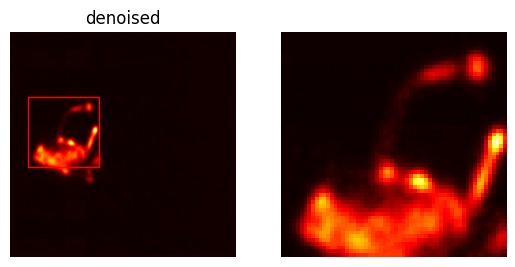

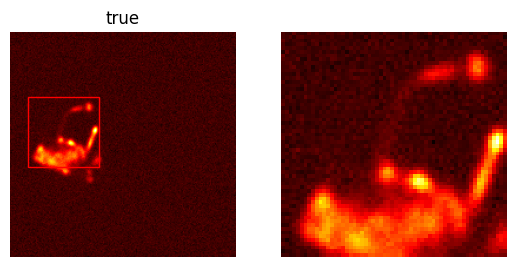

In [17]:
denoised_data = preds[0].squeeze(1).numpy()
true_data = targets[0].squeeze(1).numpy()

print(f"denoised data: {denoised_data.dtype}; shape:{denoised_data.shape}; range:({np.min(denoised_data)},{np.max(denoised_data)}); mean:{np.mean(denoised_data)}; std:{np.std(denoised_data)}")
print(f"true_data data: {true_data.dtype}; shape:{true_data.shape}; range:({np.min(true_data)},{np.max(true_data)}); mean:{np.mean(true_data)}; std:{np.std(true_data)}")


# example plot
data_range_true = np.max(true_data[11, 38]) - np.min(true_data[11, 38])
data_range_denoised = np.max(denoised_data[11, 38]) - np.min(denoised_data[11, 38])
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data[11, 38], true_data[11, 38], data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.mean(brisque_values)}")

display_image_in_detail(denoised_data[11, 38], title='denoised')
display_image_in_detail(true_data[11, 38], title='true')

In [18]:
data_range_true = np.max(true_data) - np.min(true_data)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")

#
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data, true_data, data_range=data_range)

psnr_values[np.isinf(psnr_values)] = np.nan # set inf value to nan

print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.nanmean(brisque_values)}")

data range: 2.3300607204437256


/root/miniconda3/lib/python3.8/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)
/root/miniconda3/lib/python3.8/site-packages/brisque/brisque.py:113: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)
/root/miniconda3/lib/python3.8/site-packages/brisque/brisque.py:123: RuntimeWarning: invalid value encountered in divide
  return squares_sum / ((filtered_values.shape))


calculate_metrics running: 61.34586960449815 second
PSNR: 46.92616557156954; SSIM: 0.9812147769712275; MAE: 14.14229002268985; BRISQUE: 102.815492679749


# Save denormalized denoised data into 16-bit DICOM files

restore_data: int16 shape:(24, 73, 192, 192); range:(-32768,32767); mean:-839.147827380687; std:5582.316738346289


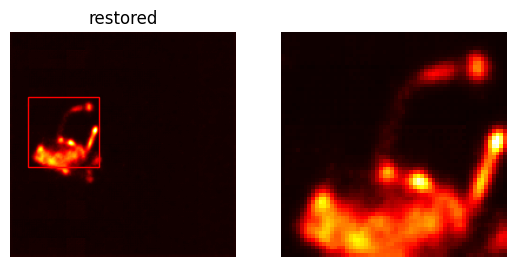

In [19]:
# denormalized denoised data
restored_data = restore_data(denoised_data, restore_info)
print(f"restore_data: {restored_data.dtype} shape:{restored_data.shape}; range:({np.min(restored_data)},{np.max(restored_data)}); mean:{np.mean(restored_data)}; std:{np.std(restored_data)}")
display_image_in_detail(restored_data[11, 38], title="restored")

In [ ]:
# save denormalized denoised data as 16-bit gray-scale .DICOM files
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/Nb2Nb_2D/PT_20p 150_120 OSEM_gaussian_0.50'

save_4d_dicom(origin_dicom_folder, restored_data, output_folder)